## (0.1) Import libraries

In [1]:
## Dependencies

import pandas as pd
import pathlib as path

import numpy as np
from scipy.stats import linregress

import matplotlib.pyplot as plt
import hvplot.pandas
import geopandas as gpd

import requests
import json
from pprint import pprint


## (0.2) define function for regression

In [38]:
def regression_plot(dataframe, col1, col2):

    x_axis = dataframe[col1]
    y_axis = dataframe[col2]

    ## calculate slope and intercept of the regression equation

    (slope, intercept, rvalue, pvalue, stderr) = linregress(x_axis, y_axis)
    
    #print the r-value

    print(f' The r^value is : {round(rvalue,3)}')

    ### generate the equation to be used as annotation
    
    regress_values = x_axis * slope + intercept
    line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

    ## generate the regression line plot 

    plt.scatter(x_axis,y_axis)
    plt.plot(x_axis,regress_values,"r-")

    plt.xlabel(col1)
    plt.ylabel(col2)
    plt.title(f'{col1} vs {col2}')

    ## Conditional Annotation position

    if slope >= 0 :
        x_annot_pos = 0.05
        y_annot_pos = 0.9
    else : x_annot_pos, y_annot_pos = 0.05, 0.1

    plt.annotate(line_eq,(x_annot_pos,y_annot_pos), fontsize=12,color="red", xycoords='axes fraction')

    plt.savefig(f'Output/Q4_regression_{col1}_vs_{col2}.png')
    plt.show()

# 1) COLLECT THE DATA

## (1.1) Countries referential
Extract the official referential of Countries used by the World Bank
- OUtput : file CSV availabe in directory Resources
- source : API World Bank
        ### this code should / must be runned once (no need to update the file)
        ## will be used below to extract data (Regions + population)
        ## can be used for different other requests

In [39]:
## retrieve all the countries in API

### generate DF Countries

page = 1   ## there are 6 pages in the json file
data = []
url_countries = 'https://api.worldbank.org/v2/country?format=json'

for page in range(1,7):
    response = requests.get(f"{url_countries}&page={page}")
    json_data = response.json()
    
    # Add the data from the current page
    data.extend(json_data[1])  
    
## create DF and select columns

countries_df = pd.DataFrame(data)
countries_df['region'] = countries_df['region'].apply(lambda x: x['value'])
countries_df = countries_df[['id', 'iso2Code', 'name', 'region','capitalCity', 'longitude', 'latitude']]

### Export to csv file

country_path = 'Output/output_countries_list_UN_referential.csv'
countries_df.to_csv(country_path)

countries_df.head()

,id,iso2Code,name,region,capitalCity,longitude,latitude
0,ABW,AW,Aruba,Latin America & Caribbean,Oranjestad,-70.0167,12.5167
1,AFE,ZH,Africa Eastern and Southern,Aggregates,,,
2,AFG,AF,Afghanistan,South Asia,Kabul,69.1761,34.5228
3,AFR,A9,Africa,Aggregates,,,
4,AFW,ZI,Africa Western and Central,Aggregates,,,


## 1.2) Collect Data for COVID deaths 
    Daily data from 2020 to 2024
    Resource : CSV file from World Health Organization : https://data.who.int/dashboards/covid19/data?n=o

In [40]:
## create DataFrame death statistics
### import and read csv file

path_deaths = 'Resources/WHO-COVID-19-global-daily-data.csv'
deaths_df = pd.read_csv(path_deaths)

deaths_df.head()

,Date_reported,Country_code,Country,WHO_region,New_cases,Cumulative_cases,New_deaths,Cumulative_deaths
0,2020-01-04,AI,Anguilla,AMR,NaN,0,NaN,0
1,2020-01-04,AZ,Azerbaijan,EUR,NaN,0,NaN,0
2,2020-01-04,BB,Barbados,AMR,NaN,0,NaN,0
3,2020-01-04,BR,Brazil,AMR,NaN,0,NaN,0
4,2020-01-04,BD,Bangladesh,SEAR,0.0,0,0.0,0


## 1.3) Collect Daily Data for COVID vaccination compaign
data by country and per day of vaccination compaign
source : https://www.kaggle.com/datasets/fedesoriano/coronavirus-covid19-vaccinations-data?resource=download

In [41]:
## create DataFrame Vaccination 

## Import and read csv file

path_Vaccination = 'Resources/vaccinations._daily.csv'
Vaccination_df = pd.read_csv(path_Vaccination)

# Vaccination _df exploration

print(Vaccination_df.shape)
print(Vaccination_df.dtypes)
print(Vaccination_df.head())

(196246, 16)
location                                object
iso_code                                object
date                                    object
total_vaccinations                     float64
people_vaccinated                      float64
people_fully_vaccinated                float64
total_boosters                         float64
daily_vaccinations_raw                 float64
daily_vaccinations                     float64
total_vaccinations_per_hundred         float64
people_vaccinated_per_hundred          float64
people_fully_vaccinated_per_hundred    float64
total_boosters_per_hundred             float64
daily_vaccinations_per_million         float64
daily_people_vaccinated                float64
daily_people_vaccinated_per_hundred    float64
dtype: object
      location iso_code        date  total_vaccinations  people_vaccinated  \
0  Afghanistan      AFG  2021-02-22                 0.0                0.0   
1  Afghanistan      AFG  2021-02-23                 NaN          

## 1.4) vaccination EOP (end of period)
csv file from World Health Organization website 
https://data.who.int/dashboards/covid19/data?n=o
        
description : data by country and per day of vaccination compaign end of period

In [94]:
## create DataFrame Vaccination 

## Import and read csv file

path_Vaccination_eop = 'Resources/vaccination-data_EOP.csv'
Vaccination_eop_df = pd.read_csv(path_Vaccination_eop)

# Vaccination _df exploration

print(Vaccination_eop_df.shape)
print(Vaccination_eop_df.dtypes)
print(Vaccination_eop_df.head())

(215, 16)
COUNTRY                                  object
ISO3                                     object
WHO_REGION                               object
DATA_SOURCE                              object
DATE_UPDATED                             object
TOTAL_VACCINATIONS                      float64
PERSONS_VACCINATED_1PLUS_DOSE           float64
TOTAL_VACCINATIONS_PER100               float64
PERSONS_VACCINATED_1PLUS_DOSE_PER100    float64
PERSONS_LAST_DOSE                       float64
PERSONS_LAST_DOSE_PER100                float64
VACCINES_USED                           float64
FIRST_VACCINE_DATE                       object
NUMBER_VACCINES_TYPES_USED              float64
PERSONS_BOOSTER_ADD_DOSE                float64
PERSONS_BOOSTER_ADD_DOSE_PER100         float64
dtype: object
       COUNTRY ISO3 WHO_REGION DATA_SOURCE DATE_UPDATED  TOTAL_VACCINATIONS  \
0        Aruba  ABW       AMRO   REPORTING   2023-12-29            217124.0   
1  Afghanistan  AFG       EMRO   REPORTING   2023-

## 1.5) Collect total Population for each country
        API World Bank : https://api.worldbank.org/v2/country/{COUNTRY}/indicator/{INDICATOR}?date={Time Periode}&format=json


In [6]:
print(f"start code")
print('---------------------------')

## create list of countries from previous DF

country_list = countries_df['id'].tolist()

# gdp_list = []
pop_list = []

# indicator = ['NY.GDP.PCAP.CD','SP.POP.TOT']

# each country has its onwn end Point, so need to loop through all end points and extract needed data

for id in country_list :

    print(f"--------------------------")
    print(f"country {id}")

    ## collect data for Population

    try:

        link_pop = f'https://api.worldbank.org/v2/country/{id}/indicator/SP.POP.TOTL?date=2019:2023&format=json'
        response_pop = requests.get(link_pop).json()

        # pprint(response_pop)

        pop_list.append({
            'country_ID' : response_pop[1][0]['countryiso3code'],
            'country_ID_2' : response_pop[1][0]['country']['id'],
            'country_name' : response_pop[1][0]['country']['value'],              
            'pop_2023' : response_pop[1][0]['value'] ,
            'pop_2022' :response_pop[1][1]['value'] ,
            'pop_2021' :response_pop[1][2]['value'] ,
            'pop_2020' : response_pop[1][3]['value'],
            'pop_2019' : response_pop[1][4]['value']
            })
    except:   
        print("Country not found POP. Skipping...")


    ## collect data for GDP

    # try:  
    #     link_gdp = f'https://api.worldbank.org/v2/country/{id}/indicator/NY.GDP.PCAP.CD?date=2019:2023&format=json'
    #     response_gdp = requests.get(link_gdp).json()

    #     # pprint(response_gdp)

    #     gdp_list.append({
    #         'country_ID' : response_gdp[1][0]['countryiso3code'],
    #         'country_ID_2' : response_gdp[1][0]['country']['id'],
    #         'country_name' : response_gdp[1][0]['country']['value'],
    #         'GDPcap_2023' : response_gdp[1][0]['value'] ,
    #         'GDPcap_2022' : response_gdp[1][1]['value'] ,
    #         'GDPcap_2021' : response_gdp[1][2]['value'] ,
    #         'GDPcap_2020' : response_gdp[1][3]['value'],
    #         'GDPcap_2019' : response_gdp[1][4]['value']
    #         })
        

    # except: 
    #     print("Country not found GDP. Skipping...")



start code
---------------------------
--------------------------
country ABW
--------------------------
country AFE
--------------------------
country AFG
--------------------------
country AFR
Country not found POP. Skipping...
--------------------------
country AFW
--------------------------
country AGO
--------------------------
country ALB
--------------------------
country AND
--------------------------
country ARB
--------------------------
country ARE
--------------------------
country ARG
--------------------------
country ARM
--------------------------
country ASM
--------------------------
country ATG
--------------------------
country AUS
--------------------------
country AUT
--------------------------
country AZE
--------------------------
country BDI
--------------------------
country BEA
Country not found POP. Skipping...
--------------------------
country BEC
Country not found POP. Skipping...
--------------------------
country BEL
--------------------------
country BE

In [7]:
## Create DF

# gdp_df = pd.DataFrame(gdp_list)

pop_df = pd.DataFrame(pop_list)
pop_df = pop_df.dropna(how='all')

pop_df.head()

,country_ID,country_ID_2,country_name,pop_2023,pop_2022,pop_2021,pop_2020,pop_2019
0,ABW,AW,Aruba,106277.0,106445.0,106537.0,106585.0,106442.0
1,AFE,ZH,Africa Eastern and Southern,739108306.0,720859132.0,702977106.0,685112979.0,667242986.0
2,AFG,AF,Afghanistan,42239854.0,41128771.0,40099462.0,38972230.0,37769499.0
3,AFW,ZI,Africa Western and Central,502789511.0,490330870.0,478185907.0,466189102.0,454306063.0
4,AGO,AO,Angola,36684202.0,35588987.0,34503774.0,33428486.0,32353588.0


# 2) PROCESS THE DATA
cleaning and tranformation

## 2.1) deaths data cleaning

In [42]:
# exploration death_df 

print(deaths_df.shape)
print(deaths_df.dtypes)

(413760, 8)
Date_reported         object
Country_code          object
Country               object
WHO_region            object
New_cases            float64
Cumulative_cases       int64
New_deaths           float64
Cumulative_deaths      int64
dtype: object


In [43]:
## use countries referential to standardize countries names

death_clean_df = pd.merge(deaths_df,countries_df,left_on="Country_code",right_on='iso2Code')

## select columns
death_clean_df = death_clean_df[['name','iso2Code','id','region','Date_reported','New_deaths','Cumulative_deaths']]
death_clean_df.head()


,name,iso2Code,id,region,Date_reported,New_deaths,Cumulative_deaths
0,Azerbaijan,AZ,AZE,Europe & Central Asia,2020-01-04,NaN,0
1,Barbados,BB,BRB,Latin America & Caribbean,2020-01-04,NaN,0
2,Brazil,BR,BRA,Latin America & Caribbean,2020-01-04,NaN,0
3,Bangladesh,BD,BGD,South Asia,2020-01-04,0.0,0
4,Curacao,CW,CUW,Latin America & Caribbean,2020-01-04,NaN,0


In [44]:
### change data type for columns INT + date

death_clean_df = death_clean_df.astype({
                            'Date_reported' : 'datetime64[ns]',
                            'New_deaths': "Float64",  
                            'Cumulative_deaths' : 'Float64'
                            })

### add columns Year + Month
death_clean_df['year'] = death_clean_df['Date_reported'].dt.year
death_clean_df['month'] = death_clean_df['Date_reported'].dt.month

### Rename col
death_clean_df = death_clean_df.rename(columns={'Date_reported' : 'date',
                                      'name':'country',
                                      'id' : 'country_id',
                                      'iso2Code':'country_id_2',
                                      'Cumulative_deaths':'total_deaths'
                                      })



death_clean_df.dtypes

country                 object
country_id_2            object
country_id              object
region                  object
date            datetime64[ns]
New_deaths             Float64
total_deaths           Float64
year                     int32
month                    int32
dtype: object

In [45]:
death_clean_df.head()

,country,country_id_2,country_id,region,date,New_deaths,total_deaths,year,month
0,Azerbaijan,AZ,AZE,Europe & Central Asia,2020-01-04,<NA>,0.0,2020,1
1,Barbados,BB,BRB,Latin America & Caribbean,2020-01-04,<NA>,0.0,2020,1
2,Brazil,BR,BRA,Latin America & Caribbean,2020-01-04,<NA>,0.0,2020,1
3,Bangladesh,BD,BGD,South Asia,2020-01-04,0.0,0.0,2020,1
4,Curacao,CW,CUW,Latin America & Caribbean,2020-01-04,<NA>,0.0,2020,1


### 2.2 Deaths by country
cleaning + transformation

In [132]:
### count of total deaths by country GRoupBy

deaths_country_df = death_clean_df[['country','country_id','country_id_2','region','total_deaths']].groupby('country').agg({
    'total_deaths': 'max',
    'country_id': 'first',
    'country_id_2': 'first',
    'region': 'first'
    })


deaths_country_df = deaths_country_df.reset_index()
deaths_country_df 
# death_total_country.sort_values(ascending=False)

,country,total_deaths,country_id,country_id_2,region
0,Afghanistan,7998.0,AFG,AF,South Asia
1,Albania,3605.0,ALB,AL,Europe & Central Asia
2,Algeria,6881.0,DZA,DZ,Middle East & North Africa
3,American Samoa,34.0,ASM,AS,East Asia & Pacific
4,Andorra,159.0,AND,AD,Europe & Central Asia
...,...,...,...,...,...
214,Virgin Islands (U.S.),132.0,VIR,VI,Latin America & Caribbean
215,West Bank and Gaza,5708.0,PSE,PS,Middle East & North Africa
216,"Yemen, Rep.",2159.0,YEM,YE,Middle East & North Africa
217,Zambia,4078.0,ZMB,ZM,Sub-Saharan Africa


### 2.3 Deaths Daily evolution
cleaning + transformation


In [47]:
## create DF for daily evolution

deaths_daily_df = death_clean_df[['date','New_deaths']].groupby(['date']).sum('New_deaths')
deaths_daily_df = deaths_daily_df.reset_index()
deaths_daily_df

,date,New_deaths
0,2020-01-04,0.0
1,2020-01-05,3.0
2,2020-01-06,0.0
3,2020-01-07,0.0
4,2020-01-08,0.0
...,...,...
1719,2024-09-18,0.0
1720,2024-09-19,0.0
1721,2024-09-20,0.0
1722,2024-09-21,1.0


### 2.3.1) daily deaths : remove outliers
IQR method

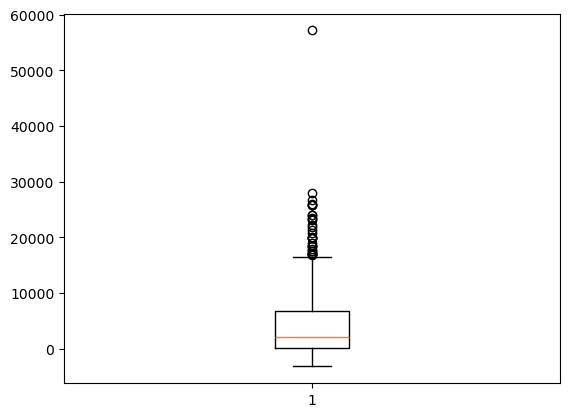

In [48]:
### identify outliers

plt.boxplot(deaths_daily_df['New_deaths'])
plt.show()

In [49]:
### Identify outliers ; IQR method

var = deaths_daily_df['New_deaths']
q1 = np.quantile(var, 0.25) 
q3 = np.quantile(var, 0.75)   
iqr = q3 - q1
outliers = var[(var > (q3 + (iqr * 1.5))) | (var < (q1 - (iqr * 1.5)))].tolist()

print(f'Q1= {q1}')
print(f'Q3= {q3}')
print(f'iqr= {iqr}')
print(outliers)


Q1= 207.0
Q3= 6744.5
iqr= 6537.5
[17151.0, 17072.0, 18955.0, 21321.0, 23939.0, 23069.0, 24027.0, 25785.0, 25887.0, 22189.0, 23448.0, 25948.0, 26731.0, 27929.0, 25897.0, 23249.0, 21827.0, 16928.0, 17105.0, 17972.0, 19949.0, 20054.0, 20774.0, 19854.0, 18431.0, 19866.0, 17570.0, 17560.0, 18442.0, 18416.0, 17104.0, 57166.0]


In [50]:
### remove outliers

deaths_daily_clean_df = deaths_daily_df[~deaths_daily_df['New_deaths'].isin(outliers)]
deaths_daily_clean_df

,date,New_deaths
0,2020-01-04,0.0
1,2020-01-05,3.0
2,2020-01-06,0.0
3,2020-01-07,0.0
4,2020-01-08,0.0
...,...,...
1719,2024-09-18,0.0
1720,2024-09-19,0.0
1721,2024-09-20,0.0
1722,2024-09-21,1.0


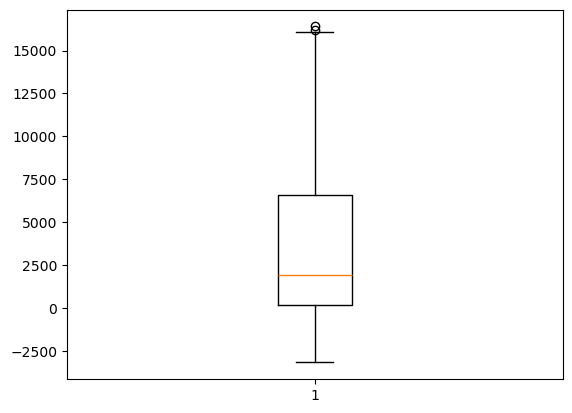

In [51]:
###last check

plt.boxplot(deaths_daily_clean_df['New_deaths'])
plt.show()

### 2.3.1) daily deaths : calculate a moving average

In [52]:
## Calculate a moving average

## define number of days 
x_days=7 

## calculate + create a list + add to a new columns

deaths_smooth_list= []

for i in range((x_days), (len(deaths_daily_clean_df))):

    daily_smooth = deaths_daily_clean_df['New_deaths'].iloc[(i-x_days):i].mean()
    deaths_smooth_list.append(daily_smooth)

# Insert the first day manually (since there's no previous day for the first value)
for j in range(0,x_days) :
    deaths_smooth_list.insert((j), deaths_smooth_list[0])



# Add the daily flow to the DataFrame
deaths_daily_clean_df['daily_deaths_smooth'] = deaths_smooth_list

# death_daily_clean_df.to_csv('Output/test4.csv')
deaths_daily_clean_df

C:\Users\nazim\AppData\Local\Temp\ipykernel_52524\978539372.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  deaths_daily_clean_df['daily_deaths_smooth'] = deaths_smooth_list


,date,New_deaths,daily_deaths_smooth
0,2020-01-04,0.0,0.428571
1,2020-01-05,3.0,0.428571
2,2020-01-06,0.0,0.428571
3,2020-01-07,0.0,0.428571
4,2020-01-08,0.0,0.428571
...,...,...,...
1719,2024-09-18,0.0,132.428571
1720,2024-09-19,0.0,132.428571
1721,2024-09-20,0.0,132.428571
1722,2024-09-21,1.0,132.428571


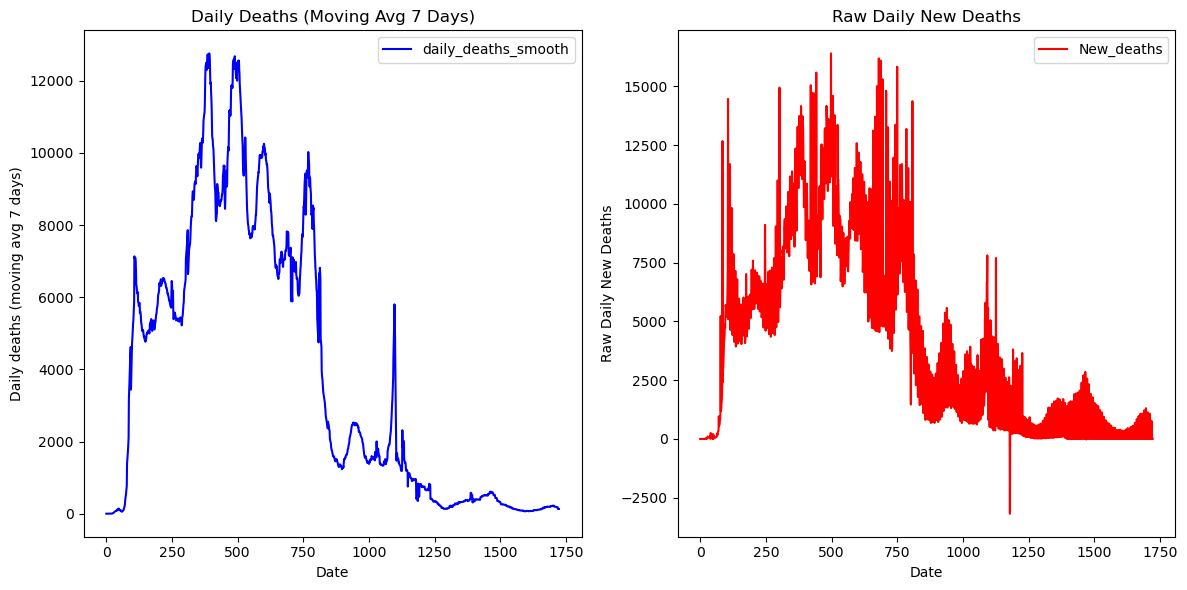

In [53]:

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))  # 1 row, 2 columns

# First subplot - Smoothed daily deaths (7-day moving average)
deaths_daily_clean_df.plot(kind='line', y="daily_deaths_smooth", ax=ax1, color='blue')
ax1.set_title('Daily Deaths (Moving Avg 7 Days)')
ax1.set_ylabel('Daily deaths (moving avg 7 days)')
ax1.set_xlabel('Date')

# Second subplot - Raw new deaths
deaths_daily_clean_df.plot(kind='line', y="New_deaths", ax=ax2, color='red')
ax2.set_title('Raw Daily New Deaths')
ax2.set_ylabel('Raw Daily New Deaths')
ax2.set_xlabel('Date')

# Adjust the layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()


## 2.4) cleaning and transform :  Vaccination Data end of period

In [95]:
Vaccination_eop_df.head()

,COUNTRY,ISO3,WHO_REGION,DATA_SOURCE,DATE_UPDATED,TOTAL_VACCINATIONS,PERSONS_VACCINATED_1PLUS_DOSE,TOTAL_VACCINATIONS_PER100,PERSONS_VACCINATED_1PLUS_DOSE_PER100,PERSONS_LAST_DOSE,PERSONS_LAST_DOSE_PER100,VACCINES_USED,FIRST_VACCINE_DATE,NUMBER_VACCINES_TYPES_USED,PERSONS_BOOSTER_ADD_DOSE,PERSONS_BOOSTER_ADD_DOSE_PER100
0,Aruba,ABW,AMRO,REPORTING,2023-12-29,217124.0,90493.0,203.0,85.0,84363.0,79.0,NaN,2021-02-17,NaN,35659.0,33.0
1,Afghanistan,AFG,EMRO,REPORTING,2023-12-31,22964750.0,19151369.0,59.0,49.0,18370386.0,47.0,NaN,2021-02-22,NaN,2729940.0,7.0
2,Angola,AGO,AFRO,REPORTING,2023-12-31,27819132.0,16550642.0,85.0,50.0,9609080.0,29.0,NaN,2021-03-10,NaN,3067091.0,9.0
3,Anguilla,AIA,AMRO,REPORTING,2023-12-29,24864.0,10858.0,166.0,72.0,10382.0,69.0,NaN,2021-02-05,NaN,3231.0,22.0
4,Albania,ALB,EURO,REPORTING,2023-12-23,3088966.0,1349255.0,107.0,47.0,1279333.0,44.0,NaN,2021-01-13,NaN,402371.0,14.0


In [96]:
Vaccination_eop_df.columns

Index(['COUNTRY', 'ISO3', 'WHO_REGION', 'DATA_SOURCE', 'DATE_UPDATED',
       'TOTAL_VACCINATIONS', 'PERSONS_VACCINATED_1PLUS_DOSE',
       'TOTAL_VACCINATIONS_PER100', 'PERSONS_VACCINATED_1PLUS_DOSE_PER100',
       'PERSONS_LAST_DOSE', 'PERSONS_LAST_DOSE_PER100', 'VACCINES_USED',
       'FIRST_VACCINE_DATE', 'NUMBER_VACCINES_TYPES_USED',
       'PERSONS_BOOSTER_ADD_DOSE', 'PERSONS_BOOSTER_ADD_DOSE_PER100'],
      dtype='object')

In [99]:
### select columns
Vaccination_eop_clean_df = Vaccination_eop_df[['COUNTRY','ISO3','TOTAL_VACCINATIONS']]
Vaccination_eop_clean_df = Vaccination_eop_clean_df.rename(columns={'COUNTRY':'country',
                                                'TOTAL_VACCINATIONS':'total_vaccination',
                                                'ISO3':'country_id'
                                                })
Vaccination_eop_clean_df.head()

,country,country_id,total_vaccination
0,Aruba,ABW,217124.0
1,Afghanistan,AFG,22964750.0
2,Angola,AGO,27819132.0
3,Anguilla,AIA,24864.0
4,Albania,ALB,3088966.0


## 2.5) cleaning and transform :  vaccination by country

In [101]:
vaccination_country_df = Vaccination_eop_clean_df

vaccination_country_df

,country,country_id,total_vaccination
0,Aruba,ABW,217124.0
1,Afghanistan,AFG,22964750.0
2,Angola,AGO,27819132.0
3,Anguilla,AIA,24864.0
4,Albania,ALB,3088966.0
...,...,...,...
210,"Taiwan, China",TWN,NaN
211,Viet Nam,VNM,266492149.0
212,Vanuatu,VUT,355430.0
213,Wallis and Futuna,WLF,17303.0


### 2.6) cleaning and transform :  vaccination daily

In [57]:
vaccination_daily_df = Vaccination_df[['date','daily_people_vaccinated']].groupby(['date']).sum()


vaccination_daily_df = vaccination_daily_df.reset_index()
vaccination_daily_df = vaccination_daily_df.astype({'date':'datetime64[ns]'})

vaccination_daily_df

,date,daily_people_vaccinated
0,2020-12-02,0.0
1,2020-12-03,4.0
2,2020-12-04,4.0
3,2020-12-05,4.0
4,2020-12-06,4.0
...,...,...
1347,2024-08-10,12.0
1348,2024-08-11,7.0
1349,2024-08-12,7.0
1350,2024-08-13,1.0


2.6.1 ) identify + remove outliers

{'whiskers': [<matplotlib.lines.Line2D at 0x159d2a56c90>,
 'caps': [<matplotlib.lines.Line2D at 0x159d2a57230>,
 'boxes': [<matplotlib.lines.Line2D at 0x159d2a569c0>],
 'medians': [<matplotlib.lines.Line2D at 0x159d2a57800>],
 'fliers': [<matplotlib.lines.Line2D at 0x159d2a57aa0>],
 'means': []}

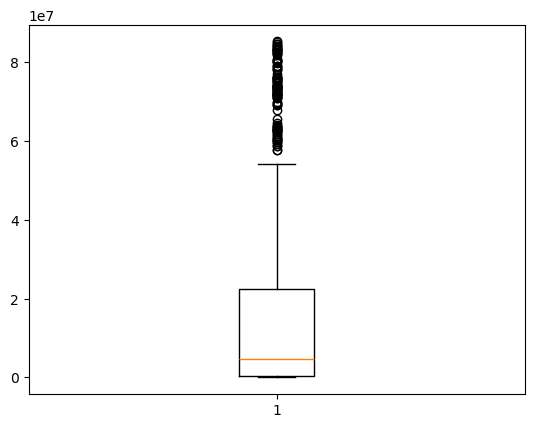

In [58]:
### identify outliers

plt.boxplot(vaccination_daily_df['daily_people_vaccinated'])

In [59]:
## Identify outliers ; IQR method


var_vaccin = vaccination_daily_df['daily_people_vaccinated']
q1 = np.quantile(var_vaccin, 0.25) 
q3 = np.quantile(var_vaccin, 0.75)   
iqr = q3 - q1
outliers_vaccin = var_vaccin[(var_vaccin > (q3 + (iqr * 1.5))) | (var_vaccin < (q1 - (iqr * 1.5)))].tolist()

print(f'Q1= {q1}')
print(f'Q3= {q3}')
print(f'iqr= {iqr}')
print(outliers_vaccin)

Q1= 324828.5
Q3= 22429195.75
iqr= 22104367.25
[70897771.0, 71244066.0, 71732291.0, 71993125.0, 71753642.0, 71755552.0, 73665876.0, 74032946.0, 75023163.0, 75707873.0, 79055077.0, 80470230.0, 80146560.0, 79794944.0, 80720552.0, 82321311.0, 82138443.0, 78902740.0, 78617038.0, 78150873.0, 77086384.0, 74176297.0, 73466296.0, 73082173.0, 72798246.0, 71590562.0, 72024639.0, 73850017.0, 74832820.0, 72709210.0, 71788304.0, 71762351.0, 73051031.0, 73946087.0, 72085920.0, 72620961.0, 73626242.0, 74085852.0, 73899498.0, 71947747.0, 69932034.0, 69515913.0, 69353397.0, 69101392.0, 69041968.0, 70971785.0, 72305993.0, 74633482.0, 76263935.0, 78084831.0, 80238088.0, 82316276.0, 82930755.0, 85100576.0, 84605700.0, 84005273.0, 83810184.0, 83098907.0, 83348732.0, 83138862.0, 81850606.0, 82435590.0, 83608485.0, 84562249.0, 85212333.0, 83980506.0, 83267156.0, 83134048.0, 82423614.0, 80223589.0, 78347396.0, 76167442.0, 75680421.0, 73917939.0, 73551130.0, 75213889.0, 75645191.0, 75829095.0, 76303572.0, 75587

In [60]:
## remove outliers

vaccination_daily_clean_df = vaccination_daily_df[~vaccination_daily_df['daily_people_vaccinated'].isin(outliers_vaccin)]
vaccination_daily_clean_df

,date,daily_people_vaccinated
0,2020-12-02,0.0
1,2020-12-03,4.0
2,2020-12-04,4.0
3,2020-12-05,4.0
4,2020-12-06,4.0
...,...,...
1347,2024-08-10,12.0
1348,2024-08-11,7.0
1349,2024-08-12,7.0
1350,2024-08-13,1.0


####     !!! : it seems we have nested outliers> dont want to change the method and remain with IQR > i accept the dataset as it is


### 2.6.2 Calculate moving average

In [61]:
## Calculate a moving average

## define number of days 
x_days = 7 

## calculate + create a list + add to a new columns

Vaccination_smooth_list= []
daily_smooth = 0

for i in range((x_days), (len(vaccination_daily_clean_df))):

    daily_smooth = vaccination_daily_clean_df['daily_people_vaccinated'].iloc[(i-x_days):i].mean()
    Vaccination_smooth_list.append(daily_smooth)

# Insert the first day manually (since there's no previous day for the first value)
for j in range(0,x_days) :
    Vaccination_smooth_list.insert((j), Vaccination_smooth_list[0])


# Add the daily flow to the DataFrame
vaccination_daily_clean_df['daily_vaccination_smooth'] = Vaccination_smooth_list

# death_daily_clean_df.to_csv('Output/test4.csv')
vaccination_daily_clean_df

C:\Users\nazim\AppData\Local\Temp\ipykernel_52524\2297840506.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vaccination_daily_clean_df['daily_vaccination_smooth'] = Vaccination_smooth_list


,date,daily_people_vaccinated,daily_vaccination_smooth
0,2020-12-02,0.0,3.428571
1,2020-12-03,4.0,3.428571
2,2020-12-04,4.0,3.428571
3,2020-12-05,4.0,3.428571
4,2020-12-06,4.0,3.428571
...,...,...,...
1347,2024-08-10,12.0,36.285714
1348,2024-08-11,7.0,31.714286
1349,2024-08-12,7.0,27.000000
1350,2024-08-13,1.0,22.857143


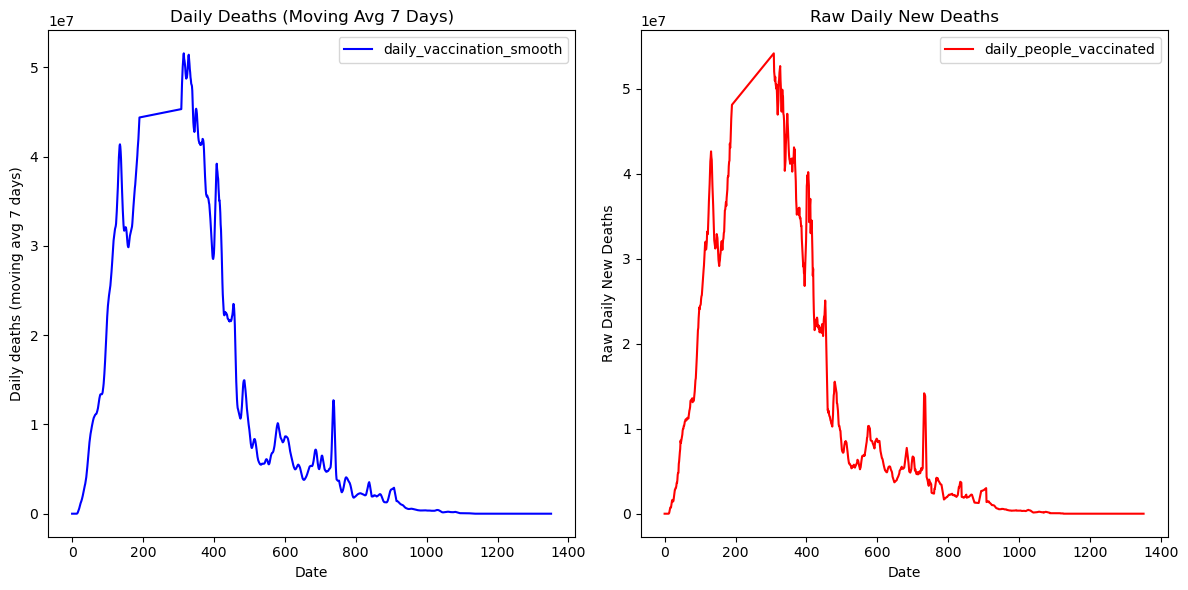

In [62]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))  # 1 row, 2 columns

# First subplot - Smoothed daily deaths (7-day moving average)
vaccination_daily_clean_df.plot(kind='line', y="daily_vaccination_smooth", ax=ax1, color='blue')
ax1.set_title('Daily Deaths (Moving Avg 7 Days)')
ax1.set_ylabel('Daily deaths (moving avg 7 days)')
ax1.set_xlabel('Date')

# Second subplot - Raw new deaths
vaccination_daily_clean_df.plot(kind='line', y="daily_people_vaccinated", ax=ax2, color='red')
ax2.set_title('Raw Daily New Deaths')
ax2.set_ylabel('Raw Daily New Deaths')
ax2.set_xlabel('Date')

# Adjust the layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

### (2.7) create a DF with full data covid
    # vacination + deaths + population
    # add coordinate from Coutries DF
    # export to csv

In [134]:
##  merge DF death_country + vaccination_country

death_vaccins_country_df = pd.merge(
                                    deaths_country_df,
                                    Vaccination_eop_clean_df,
                                    how="inner",
                                    left_on = 'country_id',
                                    right_on = 'country_id'
                                    )

death_vaccins_country_df.head()

,country_x,total_deaths,country_id,country_id_2,region,country_y,total_vaccination
0,Afghanistan,7998.0,AFG,AF,South Asia,Afghanistan,22964750.0
1,Albania,3605.0,ALB,AL,Europe & Central Asia,Albania,3088966.0
2,Algeria,6881.0,DZA,DZ,Middle East & North Africa,Algeria,15267442.0
3,Andorra,159.0,AND,AD,Europe & Central Asia,Andorra,157072.0
4,Angola,1937.0,AGO,AO,Sub-Saharan Africa,Angola,27819132.0


In [136]:
#remove useless column + rename
death_vaccins_country_df = death_vaccins_country_df.drop(columns={'country_y'})
death_vaccins_country_df = death_vaccins_country_df.rename(columns={'country_x':'country'})
death_vaccins_country_df


,country,total_deaths,country_id,country_id_2,region,total_vaccination
0,Afghanistan,7998.0,AFG,AF,South Asia,22964750.0
1,Albania,3605.0,ALB,AL,Europe & Central Asia,3088966.0
2,Algeria,6881.0,DZA,DZ,Middle East & North Africa,15267442.0
3,Andorra,159.0,AND,AD,Europe & Central Asia,157072.0
4,Angola,1937.0,AGO,AO,Sub-Saharan Africa,27819132.0
...,...,...,...,...,...,...
197,Viet Nam,43206.0,VNM,VN,East Asia & Pacific,266492149.0
198,West Bank and Gaza,5708.0,PSE,PS,Middle East & North Africa,3748571.0
199,"Yemen, Rep.",2159.0,YEM,YE,Middle East & North Africa,1298654.0
200,Zambia,4078.0,ZMB,ZM,Sub-Saharan Africa,13615707.0


In [151]:
## MERGE death_vaccins_df_clean WITH gdp_pop_df
## create fields to be analysed 

data_covid_country_df= pd.merge(
                            death_vaccins_country_df,
                            pop_df,
                            how='left',
                            left_on=  'country',
                            right_on= "country_name"                            
                            )

# add coordinate + region

data_covid_country_df = pd.merge(data_covid_country_df,
                            countries_df,
                            left_on ='country_ID',
                            right_on ='id',
                            how='left')

data_covid_country_df.head()

,country,total_deaths,country_id,country_id_2,region_x,total_vaccination,country_ID,country_ID_2,country_name,pop_2023,...,pop_2021,pop_2020,pop_2019,id,iso2Code,name,region_y,capitalCity,longitude,latitude
0,Afghanistan,7998.0,AFG,AF,South Asia,22964750.0,AFG,AF,Afghanistan,42239854.0,...,40099462.0,38972230.0,37769499.0,AFG,AF,Afghanistan,South Asia,Kabul,69.1761,34.5228
1,Albania,3605.0,ALB,AL,Europe & Central Asia,3088966.0,ALB,AL,Albania,2745972.0,...,2811666.0,2837849.0,2854191.0,ALB,AL,Albania,Europe & Central Asia,Tirane,19.8172,41.3317
2,Algeria,6881.0,DZA,DZ,Middle East & North Africa,15267442.0,DZA,DZ,Algeria,45606480.0,...,44177969.0,43451666.0,42705368.0,DZA,DZ,Algeria,Middle East & North Africa,Algiers,3.05097,36.7397
3,Andorra,159.0,AND,AD,Europe & Central Asia,157072.0,AND,AD,Andorra,80088.0,...,79034.0,77700.0,76343.0,AND,AD,Andorra,Europe & Central Asia,Andorra la Vella,1.5218,42.5075
4,Angola,1937.0,AGO,AO,Sub-Saharan Africa,27819132.0,AGO,AO,Angola,36684202.0,...,34503774.0,33428486.0,32353588.0,AGO,AO,Angola,Sub-Saharan Africa,Luanda,13.242,-8.81155


In [152]:
data_covid_country_df.columns

Index(['country', 'total_deaths', 'country_id', 'country_id_2', 'region_x',
       'total_vaccination', 'country_ID', 'country_ID_2', 'country_name',
       'pop_2023', 'pop_2022', 'pop_2021', 'pop_2020', 'pop_2019', 'id',
       'iso2Code', 'name', 'region_y', 'capitalCity', 'longitude', 'latitude'],
      dtype='object')

In [153]:
## rename clumns
data_covid_country_df = data_covid_country_df.rename(columns={'region_x':'region'})
data_covid_country_df.head()

,country,total_deaths,country_id,country_id_2,region,total_vaccination,country_ID,country_ID_2,country_name,pop_2023,...,pop_2021,pop_2020,pop_2019,id,iso2Code,name,region_y,capitalCity,longitude,latitude
0,Afghanistan,7998.0,AFG,AF,South Asia,22964750.0,AFG,AF,Afghanistan,42239854.0,...,40099462.0,38972230.0,37769499.0,AFG,AF,Afghanistan,South Asia,Kabul,69.1761,34.5228
1,Albania,3605.0,ALB,AL,Europe & Central Asia,3088966.0,ALB,AL,Albania,2745972.0,...,2811666.0,2837849.0,2854191.0,ALB,AL,Albania,Europe & Central Asia,Tirane,19.8172,41.3317
2,Algeria,6881.0,DZA,DZ,Middle East & North Africa,15267442.0,DZA,DZ,Algeria,45606480.0,...,44177969.0,43451666.0,42705368.0,DZA,DZ,Algeria,Middle East & North Africa,Algiers,3.05097,36.7397
3,Andorra,159.0,AND,AD,Europe & Central Asia,157072.0,AND,AD,Andorra,80088.0,...,79034.0,77700.0,76343.0,AND,AD,Andorra,Europe & Central Asia,Andorra la Vella,1.5218,42.5075
4,Angola,1937.0,AGO,AO,Sub-Saharan Africa,27819132.0,AGO,AO,Angola,36684202.0,...,34503774.0,33428486.0,32353588.0,AGO,AO,Angola,Sub-Saharan Africa,Luanda,13.242,-8.81155


In [154]:
## select needed columns

data_covid_country_df = data_covid_country_df[['country',
                                           'country_id','country_ID_2','region',
                                           'total_deaths', 'total_vaccination',
                                           'pop_2023',
                                           'longitude','latitude'
                                           ]]
data_covid_country_df.head()

,country,country_id,country_ID_2,region,total_deaths,total_vaccination,pop_2023,longitude,latitude
0,Afghanistan,AFG,AF,South Asia,7998.0,22964750.0,42239854.0,69.1761,34.5228
1,Albania,ALB,AL,Europe & Central Asia,3605.0,3088966.0,2745972.0,19.8172,41.3317
2,Algeria,DZA,DZ,Middle East & North Africa,6881.0,15267442.0,45606480.0,3.05097,36.7397
3,Andorra,AND,AD,Europe & Central Asia,159.0,157072.0,80088.0,1.5218,42.5075
4,Angola,AGO,AO,Sub-Saharan Africa,1937.0,27819132.0,36684202.0,13.242,-8.81155


In [106]:
## Export to CSV file 

data_covid_country_path = 'Output/Q4_output_covid_deaths_vaccin_by_country.csv'
data_covid_country_df.to_csv(data_covid_country_path)

# (3) Analysis vaccination vs deaths

## 3.1) analysis of the daily evolution

In [156]:
## Create df daily evol deaths + vaccination 
 
data_daily_df = pd.merge(
                        deaths_daily_clean_df,
                        vaccination_daily_clean_df,
                        how='left',
                        on = 'date')

# select columns + replace NAN values
data_daily_df = data_daily_df[['date','daily_deaths_smooth','daily_vaccination_smooth']]
                              
data_daily_df = data_daily_df.fillna({
                                    'daily_deaths_smooth':0,
                                    'daily_vaccination_smooth' : 0
                                    })

data_daily_df

,date,daily_deaths_smooth,daily_vaccination_smooth
0,2020-01-04,0.428571,0.0
1,2020-01-05,0.428571,0.0
2,2020-01-06,0.428571,0.0
3,2020-01-07,0.428571,0.0
4,2020-01-08,0.428571,0.0
...,...,...,...
1687,2024-09-18,132.428571,0.0
1688,2024-09-19,132.428571,0.0
1689,2024-09-20,132.428571,0.0
1690,2024-09-21,132.428571,0.0


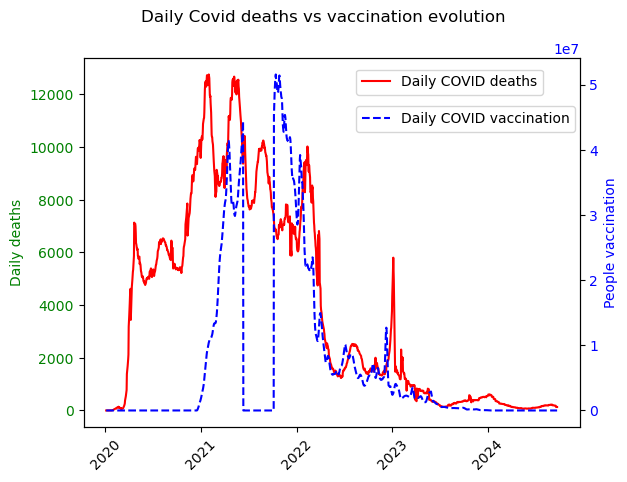

In [178]:
## Create a plot with 2 scales

x = data_daily_df['date']
y1 = data_daily_df['daily_deaths_smooth']
y2 = data_daily_df['daily_vaccination_smooth']

# Create the first plot with the first y-axis
fig, ax1 = plt.subplots()

ax1.plot(x, y1, 'r-', label='Daily COVID deaths')  # Plot y1 with green color
# ax1.set_xlabel('Date')
ax1.set_ylabel('Daily deaths', color='g')
ax1.tick_params(axis='x', rotation = 45)
ax1.tick_params(axis='y', labelcolor='g')  # Set y-axis tick labels color

# Create a second y-axis sharing the same x-axis
ax2 = ax1.twinx()
ax2.plot(x, y2, 'b--', label='Daily COVID vaccination')  # Plot y2 with blue dashed line
ax2.set_ylabel('People vaccination', color='b')
ax2.tick_params(axis='y', labelcolor='b')  # Set y-axis tick labels color

# Optional: Add title and legends
fig.suptitle('Daily Covid deaths vs vaccination evolution')
ax1.legend(loc=(0.55,0.9))
ax2.legend(loc=(0.55,0.8))

plt.savefig("Output/Q4_evolution_vaccins_deaths_daily_2021_2024.png")
plt.show()

In [179]:
# Correlation between vaccination and deaths
## clean the data when vaccination data is not available

start_date = pd.to_datetime('06-11-2021', format='%m-%d-%Y')
end_date = pd.to_datetime('10-05-2021', format='%m-%d-%Y')
end_serie =pd.to_datetime('08-15-2024', format='%m-%d-%Y')

data_daily_cleaned_df = data_daily_df[~((data_daily_df['date']>start_date) & (data_daily_df['date']<end_date))]
data_daily_cleaned_df = data_daily_cleaned_df[~(data_daily_cleaned_df['date']>end_serie)]
data_daily_cleaned_df

,date,daily_deaths_smooth,daily_vaccination_smooth
0,2020-01-04,0.428571,0.000000
1,2020-01-05,0.428571,0.000000
2,2020-01-06,0.428571,0.000000
3,2020-01-07,0.428571,0.000000
4,2020-01-08,0.428571,0.000000
...,...,...,...
1649,2024-08-11,196.857143,31.714286
1650,2024-08-12,195.714286,27.000000
1651,2024-08-13,190.142857,22.857143
1652,2024-08-14,190.285714,17.857143


 The r^value is : 0.602


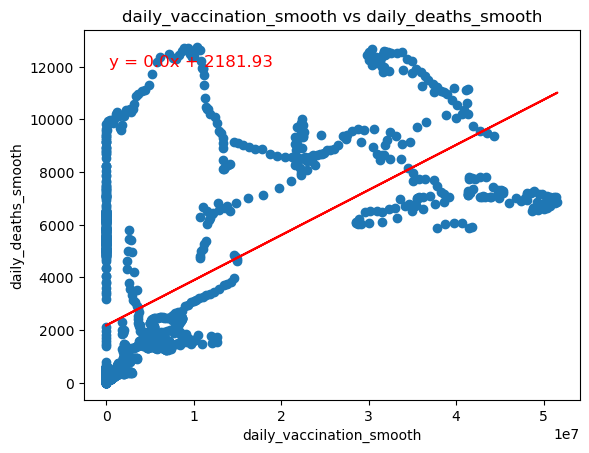

In [180]:
# Correlation between vaccination and deaths
# Build scatter plot for vaccination vs deaths on daily basis

regression_plot(data_daily_cleaned_df,'daily_vaccination_smooth', 'daily_deaths_smooth')


## 3.2 Analysis by country

In [160]:
##  merge DF death + vaccination

death_vaccins_country_df = pd.merge(
                                    deaths_country_df,
                                    vaccination_country_df,
                                    how="inner",
                                    left_on = 'country',
                                    right_on = 'country'
                                    )

death_vaccins_country_df.head()

,country,total_deaths,country_id_x,country_id_2,region,country_id_y,total_vaccination
0,Afghanistan,7998.0,AFG,AF,South Asia,AFG,22964750.0
1,Albania,3605.0,ALB,AL,Europe & Central Asia,ALB,3088966.0
2,Algeria,6881.0,DZA,DZ,Middle East & North Africa,DZA,15267442.0
3,Andorra,159.0,AND,AD,Europe & Central Asia,AND,157072.0
4,Angola,1937.0,AGO,AO,Sub-Saharan Africa,AGO,27819132.0


In [161]:
data_country_df = data_covid_country_df.copy()
data_country_df.dtypes 

country               object
country_id            object
country_ID_2          object
region                object
total_deaths         Float64
total_vaccination    float64
pop_2023             float64
longitude             object
latitude              object
dtype: object

In [162]:
## calculate vaccination %

data_country_df['vaccination%'] = data_country_df['total_vaccination']*100/data_country_df['pop_2023']

## calculate deaths/population %

data_country_df['death%'] = data_country_df['total_deaths']*100/data_country_df['pop_2023']

## calculate growth per capita % (if gdp2023 = Nan, replace with 2022 data)
# data_country['Grwth'] = np.where(data1['GDPcap_2023'].notna(),
#     (data_country['GDPcap_2023']-data_country['GDPcap_2019'])*100/(data_country['GDPcap_2019']*4),
#     (data_country['GDPcap_2022']-data_country['GDPcap_2019'])*100/(data_country['GDPcap_2019']*3))


## drop empty cells / rows
data_country_df = data_country_df.dropna(how='any')

data_country_df.head()

,country,country_id,country_ID_2,region,total_deaths,total_vaccination,pop_2023,longitude,latitude,vaccination%,death%
0,Afghanistan,AFG,AF,South Asia,7998.0,22964750.0,42239854.0,69.1761,34.5228,54.367494,0.018935
1,Albania,ALB,AL,Europe & Central Asia,3605.0,3088966.0,2745972.0,19.8172,41.3317,112.490805,0.131283
2,Algeria,DZA,DZ,Middle East & North Africa,6881.0,15267442.0,45606480.0,3.05097,36.7397,33.476475,0.015088
3,Andorra,AND,AD,Europe & Central Asia,159.0,157072.0,80088.0,1.5218,42.5075,196.124263,0.198532
4,Angola,AGO,AO,Sub-Saharan Africa,1937.0,27819132.0,36684202.0,13.242,-8.81155,75.834093,0.00528


C:\Users\nazim\AppData\Local\Temp\ipykernel_52524\4159803020.py:10: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data1_dict.values(),labels=data1_dict.keys())


<function matplotlib.pyplot.show(close=None, block=None)>

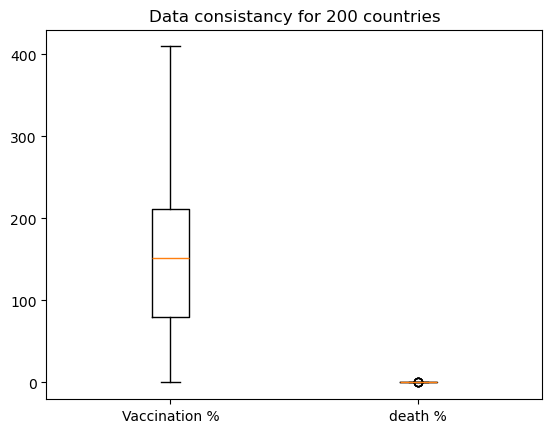

In [163]:
## identify outlayers

lenth = len(data_country_df['country'])

data1_dict = {
    'Vaccination %': data_country_df['vaccination%'],
    'death %' : data_country_df['death%'],
    }

plt.boxplot(data1_dict.values(),labels=data1_dict.keys())
plt.title(f'Data consistancy for {lenth} countries')

# plt.savefig("Output/boxplots.png")
plt.show

C:\Users\nazim\AppData\Local\Temp\ipykernel_52524\1769461082.py:14: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


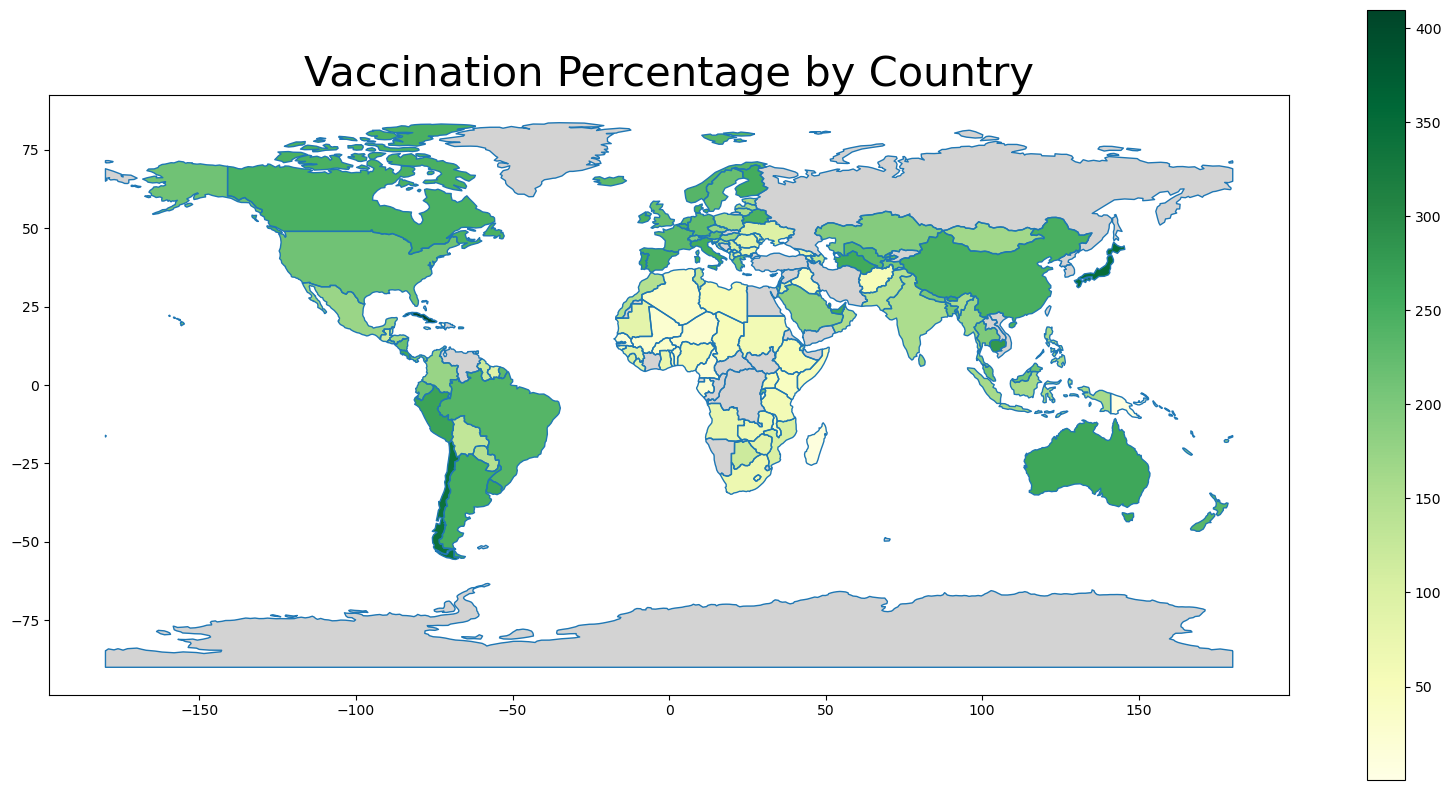

In [165]:
## Create a world map with Vaccination %


## change US name to fit with world_df
data_country_df['country'] = data_country_df['country'].replace({'United States': 'United States of America'})


data = pd.DataFrame({
    'country_name': data_country_df['country'],  
    'vaccination': data_country_df['vaccination%']  
})

# Load the world map
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Merge the GeoDataFrame with your data
world = world.merge(data, how="left", left_on="name", right_on="country_name")

# Plot the choropleth map
fig, ax = plt.subplots(1, 1, figsize=(20, 10))
world.boundary.plot(ax=ax, linewidth=1)
world.plot(column='vaccination', ax=ax, legend=True,
           cmap='YlGn', missing_kwds={"color": "lightgrey"})

plt.title('Vaccination Percentage by Country', fontsize = 30)
plt.savefig("Output/Q4_Vaccination%_worldwide.png")

plt.show()

C:\Users\nazim\AppData\Local\Temp\ipykernel_52524\3357730849.py:14: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


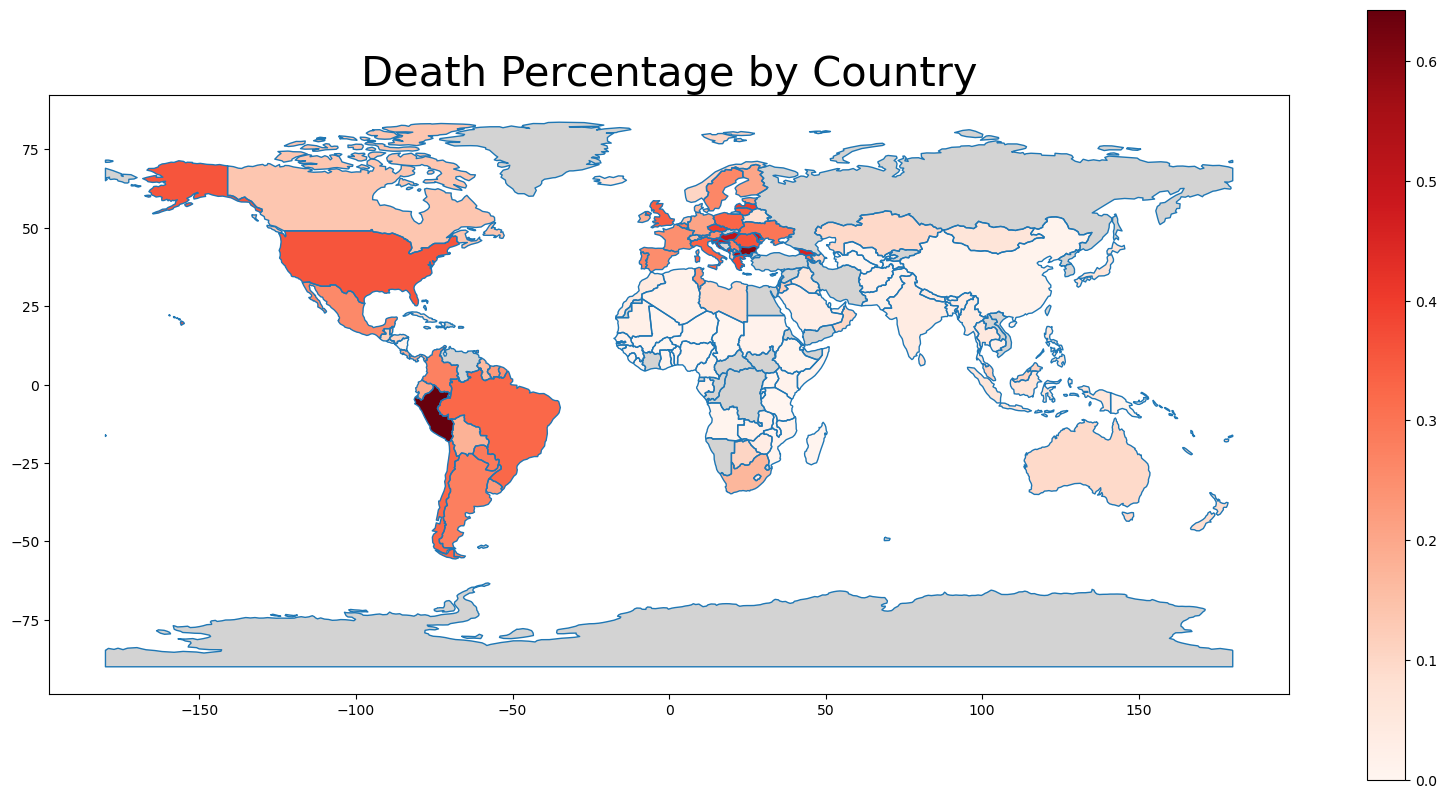

In [166]:
## Create a world map with deaths %


## change US name to fit with world_df
data_country_df['country'] = data_country_df['country'].replace({'United States': 'United States of America'})


data = pd.DataFrame({
    'country_name': data_country_df['country'],  
    'death_percentage': data_country_df['death%']  
})

# Load the world map
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Merge the GeoDataFrame with your data
world = world.merge(data, how="left", left_on="name", right_on="country_name")

# Plot the choropleth map
fig, ax = plt.subplots(1, 1, figsize=(20, 10))
world.boundary.plot(ax=ax, linewidth=1)
world.plot(column='death_percentage', ax=ax, legend=True,
           cmap='Reds', missing_kwds={"color": "lightgrey"})

plt.title('Death Percentage by Country', fontsize = 30)
plt.savefig("Output/Q4_death%_worlwide.png")

plt.show()

 The r^value is : 0.2


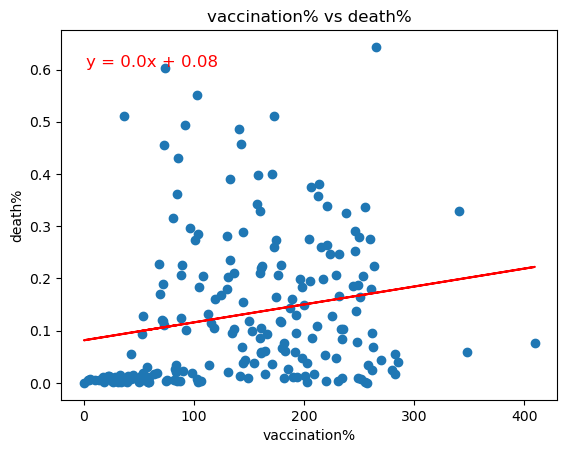

In [167]:
# Build scatter plot for vaccination vs deaths

regression_plot(data_country_df,'vaccination%', 'death%')

## 3.3) Analyse by Region

In [169]:
data_country_df = data_covid_country_df.copy()
data_country_df.dtypes 

data_regions_df = data_country_df.groupby(['region']).agg({
                        'total_deaths' : 'sum',
                        'total_vaccination': 'sum',
                        'pop_2023': 'sum',
                        })

## calculate vaccination % /population %

data_regions_df['vaccination%'] = data_regions_df['total_vaccination']*100/data_regions_df['pop_2023']

# calculate deaths/population %

data_regions_df['deaths%'] = data_regions_df['total_deaths']*100/data_regions_df['pop_2023']

# # ## calculate growth per capita % (if gdp2023 = Nan, replace with 2022 data)

# data_regions_df['Grwth'] = np.where(data_regions_df['GDPcap_2023'].notna(),
#     (data_regions_df['GDPcap_2023']-data_regions_df['GDPcap_2019'])*100/(data_regions_df['GDPcap_2019']*4),
#     (data_regions_df['GDPcap_2022']-data_regions_df['GDPcap_2019'])*100/(data_regions_df['GDPcap_2019']*3)
#     )

# # ## drop empty cells / rows
# data_regions_df = data_regions_df.dropna(how='any')

# data_regions_clean_df = data_regions_df.drop(columns = {'TOTAL_VACCINATIONS', 'Cumulative_deaths', 'GDPcap_2023', 'GDPcap_2022','GDPcap_2019', 'pop_2023'})

# data_regions_clean_df = data_regions_clean_df.sort_values('death_%', ascending=False)

data_regions_df = data_regions_df.reset_index()

data_regions_df

,region,total_deaths,total_vaccination,pop_2023,vaccination%,deaths%
0,East Asia & Pacific,637363.0,5.471900e+09,2.322403e+09,235.613731,0.027444
1,Europe & Central Asia,2261486.0,1.748753e+09,9.236164e+08,189.337616,0.244851
2,Latin America & Caribbean,1775918.0,1.382109e+09,6.640183e+08,208.143263,0.26745
3,Middle East & North Africa,327425.0,5.348561e+08,5.007873e+08,106.803055,0.065382
4,North America,1256935.0,8.109853e+08,3.750761e+08,216.218838,0.335115
5,South Asia,631069.0,3.040241e+09,1.938550e+09,156.830723,0.032554
6,Sub-Saharan Africa,169738.0,6.676276e+08,1.235545e+09,54.035083,0.013738


C:\Users\nazim\AppData\Local\Temp\ipykernel_52524\3330835086.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('viridis', len(categories))  # Get a color map


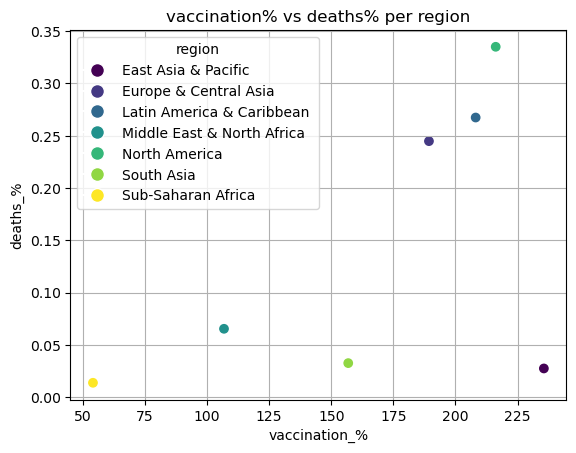

In [170]:

# Create a dictionary to map each unique category in 'col1' to a color
categories = data_regions_df['region'].unique()
colors = plt.cm.get_cmap('viridis', len(categories))  # Get a color map

# Create a color mapping for each category
color_mapping = {category: colors(i) for i, category in enumerate(categories)}

# Assign colors based on the 'region' value for each row
category_colors = data_regions_df['region'].map(color_mapping)

# Create the scatter plot with colored points
plt.scatter(data_regions_df['vaccination%'], 
            data_regions_df['deaths%'], 
            c=category_colors)

plt.xlabel('vaccination_%')
plt.ylabel('deaths_%')

# Create a custom legend
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color_mapping[category], markersize=10, label=category) 
           for category in categories]

plt.legend(handles=handles, title="region")

plt.title('vaccination% vs deaths% per region')
plt.grid()

plt.savefig("Output/Q4_vaccins_vs_deaths_per_region.png")
plt.show()


In [ ]:

# Create a dictionary to map each unique category in 'col1' to a color
categories = data_regions_df['region'].unique()
colors = plt.cm.get_cmap('viridis', len(categories))  # Get a color map

# Create a color mapping for each category
color_mapping = {category: colors(i) for i, category in enumerate(categories)}

# Assign colors based on the 'region' value for each row
category_colors = data_regions_df['region'].map(color_mapping)

# Create the scatter plot with colored points
plt.scatter(data_regions_df['vaccination%'], 
            data_regions_df['deaths%'], 
            c=category_colors)

plt.xlabel('vaccination_%')
plt.ylabel('deaths_%')

# Create a custom legend
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color_mapping[category], markersize=10, label=category) 
           for category in categories]

plt.legend(handles=handles, title="region")

plt.title('vaccination% vs deaths% per region')
plt.grid()

plt.savefig("Output/Q4_vaccins_vs_deaths_per_region.png")
plt.show()
